# Volatility and Tail Risk in Gold Prices_ A Historical Analysis (2015-2025)


## Objective
This project estimates and visualizes the evolution of **tail risk** (VaR & CVaR) and **volatility** in gold prices (GC=F) over 2015–2025 using a historical, non-parametric approach.

**Why it matters:**
Gold is often seen as a "safe haven" asset. Understanding its volatility and tail risk helps investors and policymakers gauge periods of market stress and capital preservation performance.

**Methodology:**
- Daily log returns from Yahoo Finance.
- Historical Value-at-Risk (VaR) and Conditional VaR (CVaR).
- Rolling 1-year (252-day) VaR and volatility windows.

In [35]:
#!pip install pandas-datareader
#!pip install matplotlib
#!pip install yfinance

import numpy as np
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt

## Data Import and Sanity Checks
We use `yfinance` to fetch daily gold futures data (symbol: `GC=F`).
We verify:
1. Index is sorted and monotonic.
2. No missing values.
3. Proper date coverage (2015–2025).

In [103]:
import yfinance as yf
import pandas as pd

symbol = "GC=F"
start, end = "2015-10-02", "2025-10-31"
data = yf.download(symbol, start=start, end=end, progress=False, auto_adjust=False)

data.info()
print(data.isna().sum())
print(data.index.is_monotonic_increasing)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2534 entries, 2015-10-02 to 2025-10-30
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, GC=F)  2534 non-null   float64
 1   (Close, GC=F)      2534 non-null   float64
 2   (High, GC=F)       2534 non-null   float64
 3   (Low, GC=F)        2534 non-null   float64
 4   (Open, GC=F)       2534 non-null   float64
 5   (Volume, GC=F)     2534 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 138.6 KB
Price      Ticker
Adj Close  GC=F      0
Close      GC=F      0
High       GC=F      0
Low        GC=F      0
Open       GC=F      0
Volume     GC=F      0
dtype: int64
True


### Gold Futures Price Trend
The adjusted close is plotted below. Notice clear upward trends in 2019–2020 and 2024–2025.

<Axes: title={'center': 'Gold Futures (GC=F) Price, 2015–2025'}, xlabel='Date'>

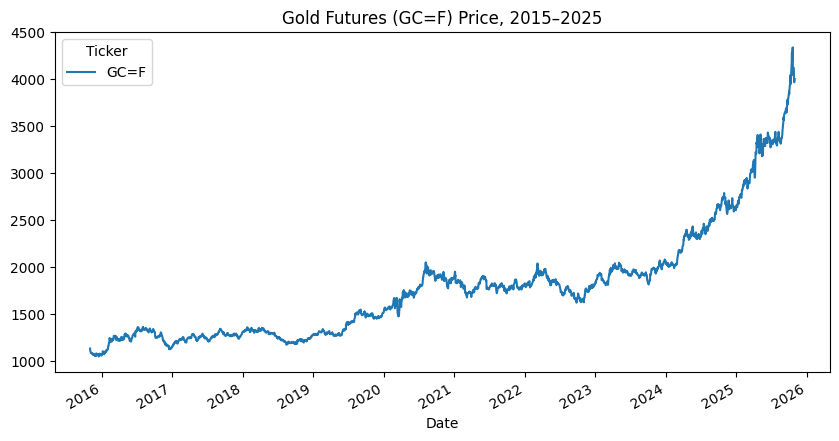

In [68]:
data['Adj Close'].plot(figsize=(10,5), title='Gold Futures (GC=F) Price, 2015–2025')

### Daily Returns, VaR, and CVaR
We calculate daily log returns to ensure additivity over time:
\[
r_t = \ln(P_t / P_{t-1})
\]
Then compute 95% and 99% VaR, and 95% CVaR (expected shortfall beyond 5% tail).

In [105]:
import numpy as np
r_log = np.log(data['Adj Close']).diff().dropna()
r = r_log.squeeze()

var95, var99 = np.quantile(r, [0.05, 0.01])
cvar95 = r[r <= var95].mean()

print(f"95% VaR = {var95:.4%}")
print(f"99% VaR = {var99:.4%}")
print(f"95% CVaR = {cvar95:.4%}")

95% VaR = -1.5677%
99% VaR = -2.6213%
95% CVaR = -2.2659%


**Interpretation:**
- 95% VaR = –1.56% → On 5% of days, gold fell more than 1.56%.
- 99% VaR = –2.63% → On 1% of days, gold fell more than 2.63%.
- 95% CVaR = –2.26% → Average loss among the worst 5% days.

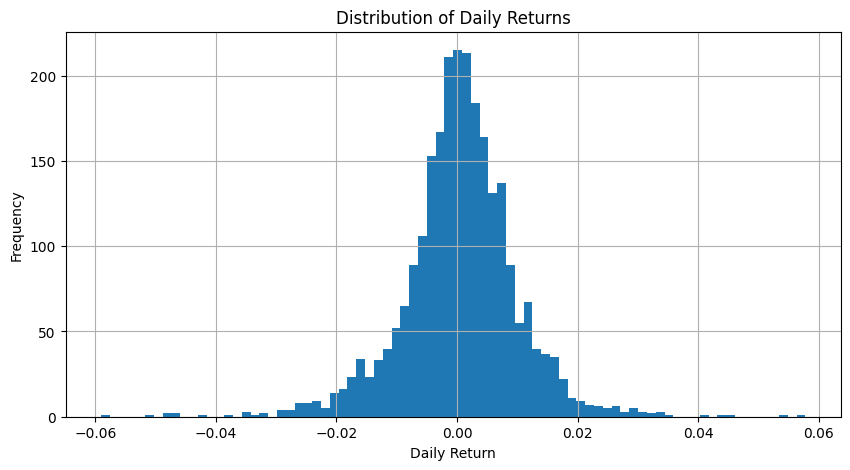

In [107]:
# --- Check for symmetry / distribution ---
r.hist(bins=80, figsize=(10,5))
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()


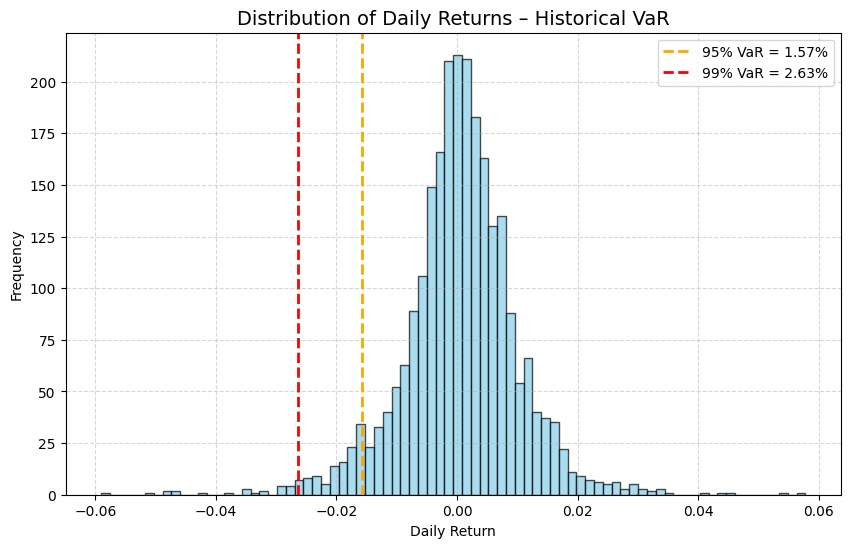

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(r, bins=80, color='skyblue', edgecolor='black', alpha=0.7)

# Mark the 95% and 99% VaR lines
plt.axvline(var95, color='orange', linestyle='--', linewidth=2, label=f'95% VaR = {VaR95_pct:.2f}%')
plt.axvline(var99, color='red', linestyle='--', linewidth=2, label=f'99% VaR = {VaR99_pct:.2f}%')

plt.title('Distribution of Daily Returns – Historical VaR', fontsize=14)
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Rolling Historical VaR (252-Day Window)
Rolling windows show how tail risk evolved through time, capturing volatility clustering and crisis periods.

In [108]:
# --- Rolling 1-Year (252-Day) 95% and 99% Historical VaR ---

window = 252  # trading days per year

rolling_var95 = r.rolling(window).quantile(0.05)
rolling_var99 = r.rolling(window).quantile(0.01)

# Drop first NaN values (from incomplete windows)
rolling_var95 = rolling_var95.dropna()
rolling_var99 = rolling_var99.dropna()

print(rolling_var95.tail())

Date
2025-10-24   -0.019811
2025-10-27   -0.020793
2025-10-28   -0.020793
2025-10-29   -0.020793
2025-10-30   -0.020793
Name: GC=F, dtype: float64


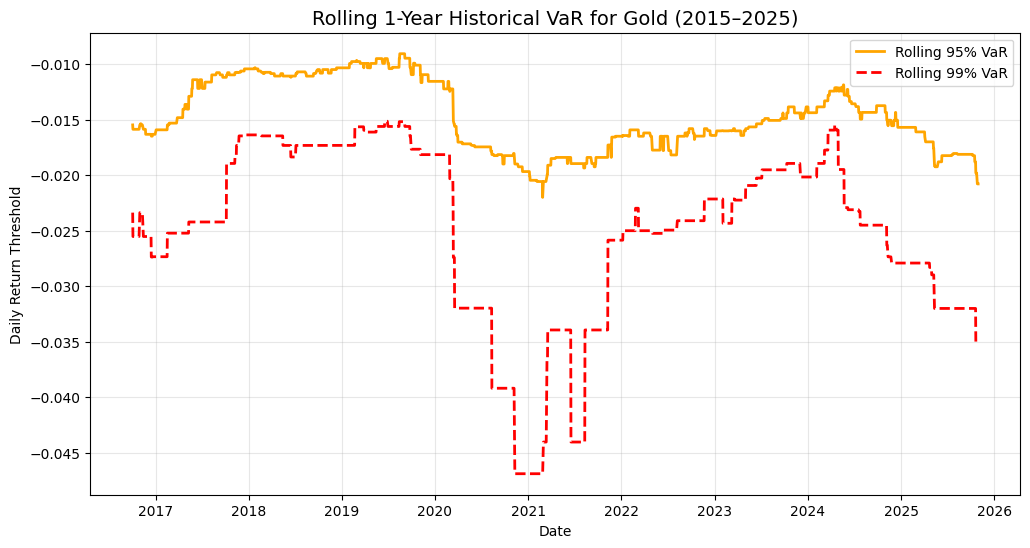

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(rolling_var95, label='Rolling 95% VaR', color='orange', linewidth=2)
plt.plot(rolling_var99, label='Rolling 99% VaR', color='red', linestyle='--', linewidth=2)
plt.title("Rolling 1-Year Historical VaR for Gold (2015–2025)", fontsize=14)
plt.ylabel("Daily Return Threshold")
plt.xlabel("Date")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**Observation:**
- 2020–2021: Spike in VaR — COVID market turbulence.
- 2022: Inflation surge & geopolitical shocks → elevated risk.
- 2024–2025: Renewed volatility after long calm: high in demand from China lead to a boom in gold price, which lead to high daily fluctuation.

### Rolling Volatility vs VaR
Volatility and VaR are closely related — VaR roughly scales with volatility.

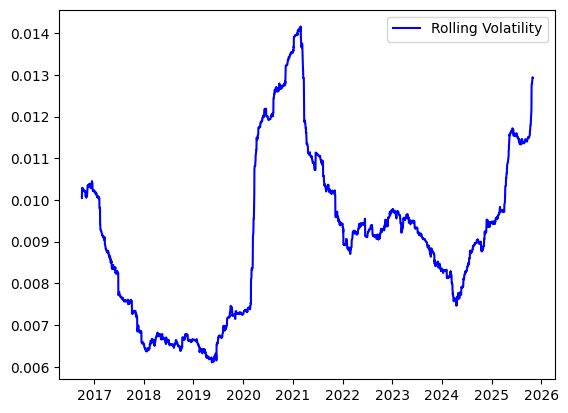

In [111]:
rolling_vol = r.rolling(window).std()
plt.plot(rolling_vol, label='Rolling Volatility', color='blue')
plt.legend()

**Rolling CVAR**

<Axes: title={'center': 'Rolling 1-Year CVaR95'}, xlabel='Date'>

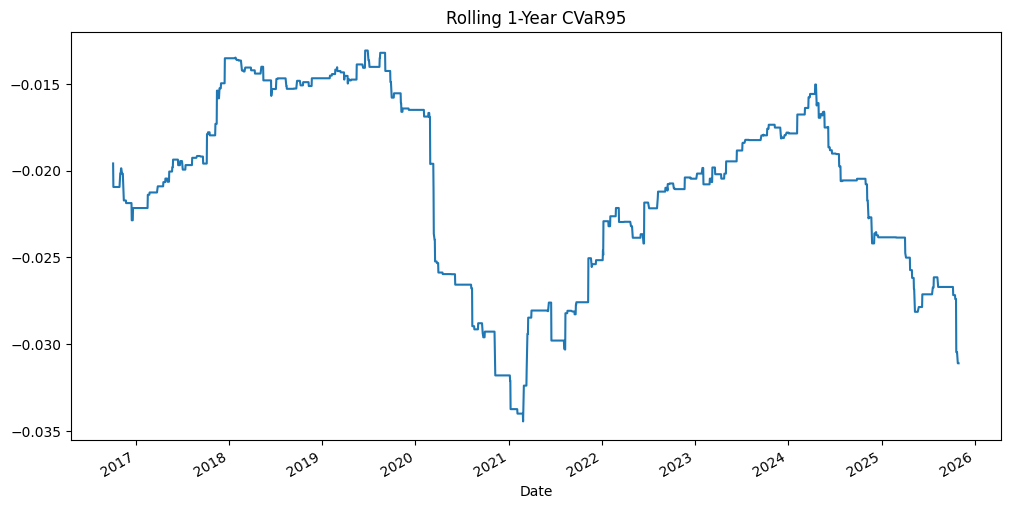

In [110]:
rolling_cvar95 = r.rolling(window).apply(lambda x: x[x <= np.quantile(x, 0.05)].mean())
rolling_cvar95.plot(title='Rolling 1-Year CVaR95', figsize=(12,6))

## Key Insights
1. **Gold is not risk-free** — its 1-day 95% loss can exceed 1.5%.
2. **Risk spikes coincide with macro shocks** (COVID-19, inflation, rate hikes).
3. **VaR and volatility rise and fall together**, confirming strong link between dispersion and tail risk.
4. **Recent years (2024–2025)** show renewed turbulence, potentially linked to monetary uncertainty.

## Limitations
- Historical VaR assumes past = future — no forward-looking model.
- Does not separate structural volatility regimes.
- Log returns ignore jumps or intraday microstructure noise.

## Future Work
- Compare **Gold vs S&P 500 VaR**.
- Estimate **Parametric (Normal/t-dist) VaR**.
- Transition to **GARCH volatility modeling** for predictive analysis.

In [113]:
px.to_csv("gold_adjclose_2015_2025.csv")